# Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Package

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk # import a popular library for working with human language data in Python
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer # It is easy to convert each word into a number
from tensorflow.keras.preprocessing import sequence # It is easy to have a consistent encoding length for each text
from sklearn.preprocessing import LabelEncoder # It is easy to map each category to a numeric label
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Prepare Dataset

## Load Course Review Dataset

In [ ]:
# Change to dataset directory
%cd /content/gdrive/MyDrive/Group9
!ls

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Group9'
/content
gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/42805/Group9
!ls

/content/gdrive/MyDrive/42805/Group9
'CNN(e).ipynb'		    course_review.ipynb        word2vec2.model
 CNN.ipynb		    LSTM.ipynb		       word2vec.model
 course_data_clean.csv	   '“LSTM (word2vec)”的副本'
 course_data_clean.gsheet   model.png


In [ ]:
# Reading the file
# file_path = "/content/gdrive/MyDrive/Group9/course_data_clean.csv"
dataset = pd.read_csv('course_data_clean.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_code        14838 non-null  object 
 1   course_title       14838 non-null  object 
 2   num_ratings        14838 non-null  int64  
 3   useful             14836 non-null  object 
 4   easy               14835 non-null  object 
 5   liked              14835 non-null  object 
 6   num_reviews        14838 non-null  int64  
 7   reviews            14829 non-null  object 
 8   course_rating      14616 non-null  object 
 9   course_rating_int  14616 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.1+ MB


In [ ]:
print(dataset['course_rating'].value_counts())

liked course       9786
disliked course    4830
Name: course_rating, dtype: int64


In [ ]:
# Create a copy of the original dataframe
removed_rows_df = dataset.copy()

# Filter out rows with missing values in the 'course_rating_int' column
removed_rows = removed_rows_df[removed_rows_df['course_rating_int'].isnull()]

# Remove the filtered rows from the original dataframe
dataset = dataset.dropna(subset=['course_rating_int'])

In [ ]:
# A view of the data
dataset.head()
dataset['reviews'].head()

0                      go to office hours and practice
1    One of my least favourite courses. Although th...
2    It starts with a very low pace but after midte...
3    Took this in 2018 with no programming experien...
4    I loved everything about cs 115. Great instruc...
Name: reviews, dtype: object

## Text Wrangling & Normalization

In [ ]:
import contractions
import numpy as np
import re
import tqdm
import unicodedata

# Remove accents from input text
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = [] # Stores each processed piece of text
  for doc in tqdm.tqdm(docs):
    doc = doc.translate(doc.maketrans("\n\t\r", "   ")) # Replace line breaks, tabs, and carriage returns with Spaces.
    doc = doc.lower() # Converts text to lowercase
    doc = remove_accented_chars(doc) # Remove the accent
    doc = contractions.fix(doc) # Substitution abbreviation
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A) # Remove special characters that are not alphanumeric or whitespace.
    doc = re.sub(' +', ' ', doc) # Remove extra space
    doc = doc.strip() # Remove spaces at both ends of the text
    norm_docs.append(doc) # Add the processed text to the norm_docs list
  
  return norm_docs

In [ ]:
# Measure the time the function executes
%%time
# Convert reviews column to list
reviews = dataset['reviews'].astype(str).tolist()
# Convert float values to integers in the label column
dataset['course_rating_int'] = dataset['course_rating_int'].round().astype(int)
# Split your dataset into training and test sets
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(
    reviews, dataset['course_rating_int'], test_size=0.4, random_state=42
)
# The code calls the pre_process_corpus method to preprocess the data in the train, validation, and test datasets.
norm_reviews = pre_process_corpus(reviews) # normalize the whole reviews
norm_train_reviews = pre_process_corpus(train_reviews) # normalize train reviews
norm_test_reviews = pre_process_corpus(test_reviews) # normalize test reviews

100%|██████████| 5847/5847 [00:00<00:00, 25172.33it/s]

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.16 s


In [ ]:
test_sentiments[:10]

8113     0
6563     1
10473    1
1238     1
13415    0
6751     1
2618     1
2356     1
11351    0
6996     1
Name: course_rating_int, dtype: int64

# Convert sentences into a sequence of numbers

In [ ]:
t = Tokenizer(oov_token='<UNK>') # Set the oov_token parameter to identify the unlogged word, where '<UNK>' represents a placeholder for the unrecognized word
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews) # Converts textual data into a sequence of numbers
t.word_index['<PAD>'] = 0 # word_index is a dictionary that maps words to integer indexes, and by setting the index of <PAD> to 0, we can easily use it to populate sequences to the same length

Understand the distribution of word codes

In [ ]:
# Find the word with the largest numeric code of all the words and its code.
max_word_index = 0
for k, v in t.word_index.items():
    if v > max_word_index:
        max_word_index = v
# Find the word with the smallest numeric code of all the words and its code.
min_word_index = float('inf') # inf means positive infinity
for k, v in t.word_index.items():
    if v < min_word_index:
        min_word_index = v
# Understand the position of unknown words in the vocabulary
unk_word_index = t.word_index['<UNK>']

Converts each text in the training and test sets to its corresponding word-encoded sequence

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print(f"Vocabulary size={len(t.word_index)}")
print(f"Number of Documents={t.document_count}")

Vocabulary size=12167
Number of Documents=8769


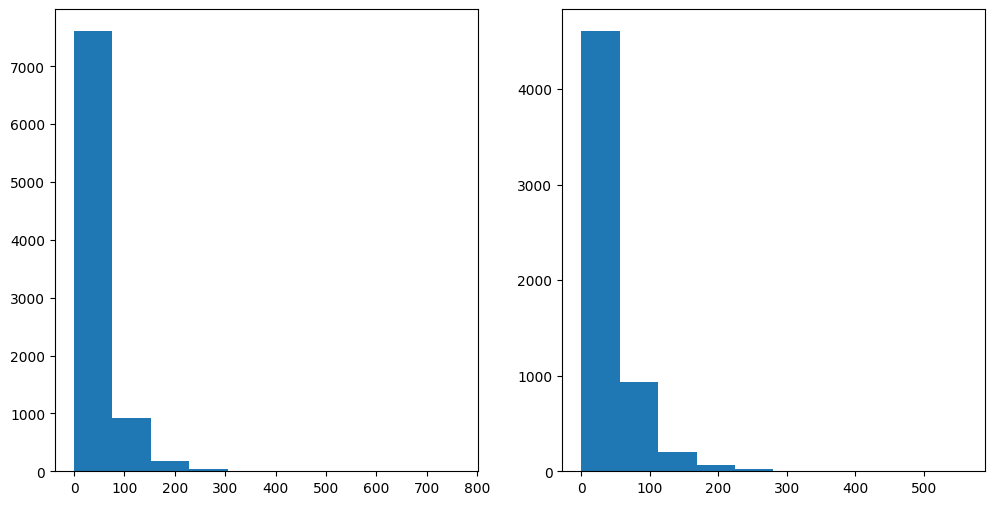

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

## Sequence Normalization

In [ ]:
# Control the length of each sentence. The maximum length is 1000. Short sentences will be filled in and long sentences will be truncated
max_seq_len = 500
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=max_seq_len)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
X_train.shape, X_test.shape

((8769, 500), (5847, 500))

# Encoding Labels

In [ ]:
le = LabelEncoder()
num_classes=2 # liked course -> 1, disliked course -> 0
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)
VOCAB_SIZE = len(t.word_index)

In [ ]:
print(VOCAB_SIZE)

12167


# Baseline model - CNN

## Create Model

In [ ]:
from keras import regularizers
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
embed_size = 500 # The dimension of each word in the embedded space
epochs = 50 # Training rounds
batch_size=128 # The number of samples selected during each iteration training
model = Sequential()
model.add(Embedding(VOCAB_SIZE, embed_size, input_length=max_seq_len))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# lr = 0.0001
# optimizer = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          6946000   
                                                                 
 conv1d (Conv1D)             (None, 500, 128)          256128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 125, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 32)           8

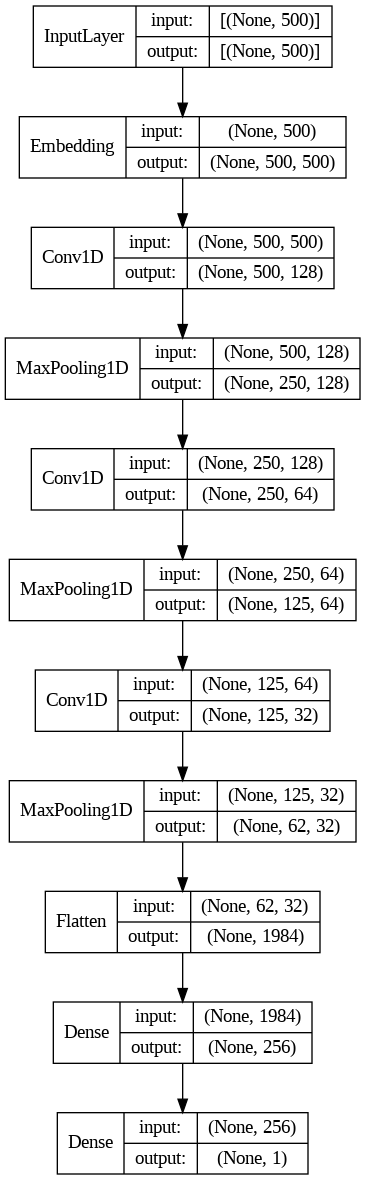

In [ ]:
import tensorflow as tf 
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Training

Epoch 1/50
83/83 [==============================] - 37s 291ms/step - loss: 0.5762 - accuracy: 0.7006 - val_loss: 0.5382 - val_accuracy: 0.7333
Epoch 2/50
83/83 [==============================] - 15s 185ms/step - loss: 0.3968 - accuracy: 0.8218 - val_loss: 0.4562 - val_accuracy: 0.7949
Epoch 3/50
83/83 [==============================] - 12s 151ms/step - loss: 0.2525 - accuracy: 0.8937 - val_loss: 0.5346 - val_accuracy: 0.7829
Epoch 4/50
83/83 [==============================] - 10s 117ms/step - loss: 0.1427 - accuracy: 0.9448 - val_loss: 0.7217 - val_accuracy: 0.7573
Epoch 5/50
83/83 [==============================] - 10s 120ms/step - loss: 0.0837 - accuracy: 0.9673 - val_loss: 0.9654 - val_accuracy: 0.7385
Epoch 6/50
83/83 [==============================] - 10s 122ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 1.0741 - val_accuracy: 0.7667
Epoch 7/50
83/83 [==============================] - 12s 152ms/step - loss: 0.0564 - accuracy: 0.9804 - val_loss: 1.1681 - val_accuracy: 0.7641

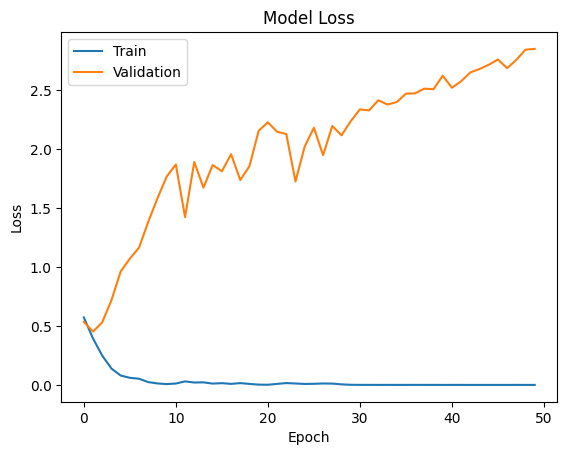

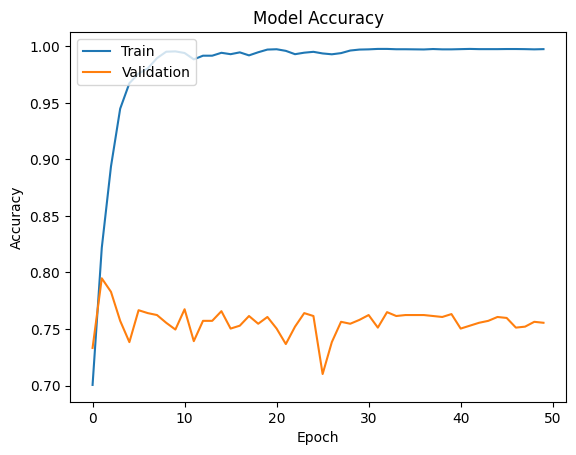

In [ ]:
import matplotlib.pyplot as plt


history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

92/92 [==============================] - 1s 6ms/step - loss: 2.8600 - accuracy: 0.7572
Accuracy: 75.72%


In [ ]:
predictions = model.predict(X_test).ravel()
predictions[:10]

92/92 [==============================] - 1s 5ms/step


array([9.9786180e-01, 9.9999774e-01, 9.8680580e-01, 1.5701418e-03,
       5.9302602e-10, 9.9258852e-01, 1.0000000e+00, 1.0000000e+00,
       2.0143210e-07, 1.0000000e+00], dtype=float32)

In [ ]:
predictions = ['liked course' if item == 1 else 'disliked course' for item in predictions]
predictions[:10]

['disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'liked course',
 'liked course',
 'disliked course',
 'liked course']

In [ ]:
from sklearn.metrics import classification_report
labels = ['disliked course', 'liked course']
y_pred = model.predict(X_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=labels))

92/92 [==============================] - 0s 5ms/step
                 precision    recall  f1-score   support

disliked course       0.65      0.60      0.63       988
   liked course       0.81      0.84      0.82      1936

       accuracy                           0.76      2924
      macro avg       0.73      0.72      0.72      2924
   weighted avg       0.75      0.76      0.75      2924



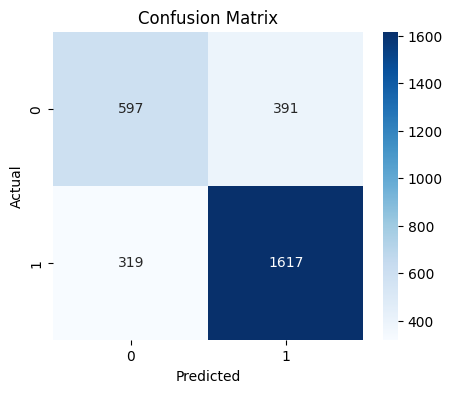

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# Customize Word2Vec

In [ ]:
from gensim.models import Word2Vec
sentences = [review.split() for review in norm_train_reviews]
"""
window = 2 Change the context window size from the default of 5 to 2
min_count = 2 The minimum number of times a word appears in a table has been changed from 5 to 2
sg = 1 Use the Skip-gram algorithm
"""
w2v_model2 = Word2Vec(sentences,window=2, min_count=2, vector_size=128, alpha=0.01)
w2v_model2.train(sentences, total_examples=len(sentences), epochs=25)

(6240025, 9006900)

In [ ]:
w2v_model2.save("word2vec2.model")

In [ ]:
print(w2v_model2.vector_size)

128


In [48]:
import numpy as np
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

embed_size = 500 # The dimension of each word in the embedded space
epochs = 50 # Training rounds
batch_size=128 # The number of samples selected during each iteration training

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(train_reviews)

# load pre-trained Word2Vec model
word2vec_model = KeyedVectors.load("/content/gdrive/MyDrive/42805/Group9/word2vec2.model")

# create embedding matrix from pre-trained Word2Vec model
#embedding_matrix = word2vec_model.wv.vectors
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# create the model
model = Sequential()
# embedding_layer = Embedding(VOCAB_SIZE, embed_size, input_length=max_seq_len,weights=[embedding_matrix],trainable=True) 
# embedding_layer.set_weights([embedding_matrix])
#model.add(embedding_layer)
# model.add(Embedding(VOCAB_SIZE, embed_size, input_length=max_seq_len,weights=[embedding_matrix],trainable=True))
# model.add(Embedding(VOCAB_SIZE, embed_size, input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
model.add(
    Embedding(
        input_dim = VOCAB_SIZE, # The size of our vocabulary 
        output_dim = embedding_dim, # Dimensions to which each words shall be mapped
        weights = [embedding_matrix],
        input_length = embed_size, # Length of input sequences
        trainable = True
    )
)
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 128)          1557376   
                                                                 
 conv1d_12 (Conv1D)          (None, 500, 128)          65664     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 250, 64)           32832     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 125, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 125, 32)          

## Training

Epoch 1/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 2.0728 - val_accuracy: 0.7571
Epoch 2/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0035 - accuracy: 0.9980 - val_loss: 2.0958 - val_accuracy: 0.7617
Epoch 3/50
62/62 [==============================] - 1s 21ms/step - loss: 0.0035 - accuracy: 0.9976 - val_loss: 2.1066 - val_accuracy: 0.7628
Epoch 4/50
62/62 [==============================] - 1s 22ms/step - loss: 0.0034 - accuracy: 0.9980 - val_loss: 2.1268 - val_accuracy: 0.7594
Epoch 5/50
62/62 [==============================] - 1s 23ms/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 2.1472 - val_accuracy: 0.7628
Epoch 6/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 2.1601 - val_accuracy: 0.7617
Epoch 7/50
62/62 [==============================] - 1s 23ms/step - loss: 0.0034 - accuracy: 0.9976 - val_loss: 2.1697 - val_accuracy: 0.7605
Epoch 8/50
62

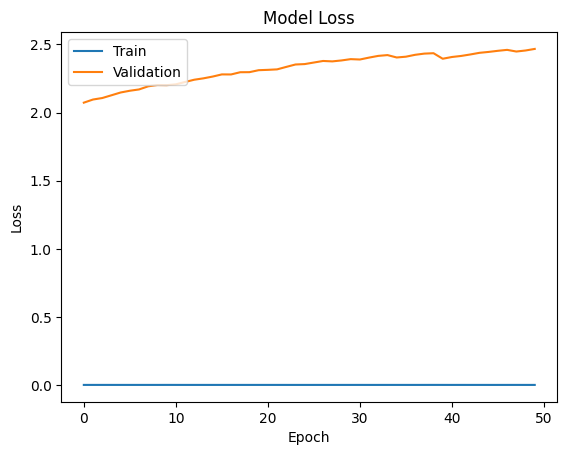

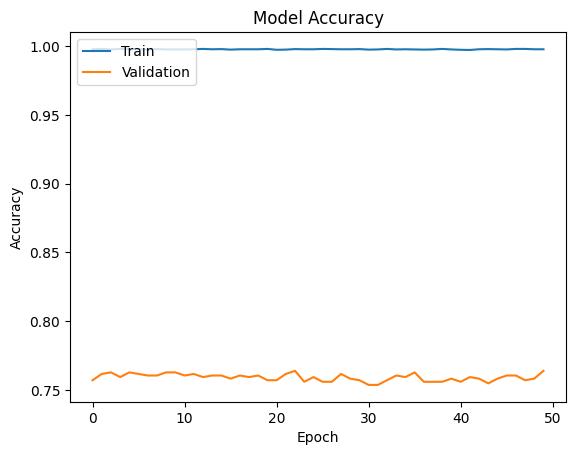

In [51]:
history = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=50, 
          batch_size=batch_size, 
          verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

In [43]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

183/183 [==============================] - 1s 4ms/step - loss: 0.9685 - accuracy: 0.7517
Accuracy: 75.17%


In [44]:
predictions = model.predict(X_test).ravel()
predictions[:]

183/183 [==============================] - 1s 3ms/step


array([0.8644624 , 0.9969338 , 0.44469142, ..., 0.9999336 , 0.66655797,
       0.99147403], dtype=float32)

In [45]:
predictions = ['liked course' if item == 1 else 'disliked course' for item in predictions]
predictions[:10]

['disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course']

In [46]:
from sklearn.metrics import classification_report
labels = ['disliked course', 'liked course']
y_pred = model.predict(X_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=labels))

183/183 [==============================] - 1s 3ms/step
                 precision    recall  f1-score   support

disliked course       0.64      0.59      0.61      1958
   liked course       0.80      0.83      0.82      3889

       accuracy                           0.75      5847
      macro avg       0.72      0.71      0.72      5847
   weighted avg       0.75      0.75      0.75      5847



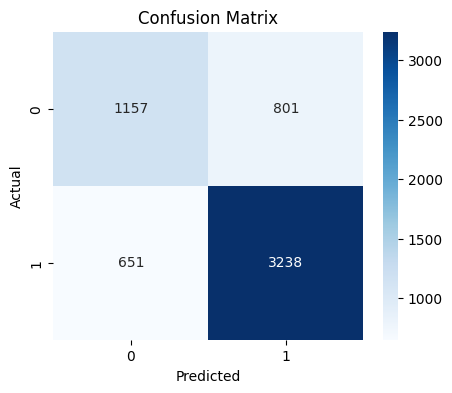

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# Train with GloVe pre-trained Word2Vec

## Create Model

In [ ]:
# Load GloVe embeddings
glove_model = KeyedVectors.load('/content/gdrive/MyDrive/42805/Group9/glove.6B.100d.txt')

In [29]:
# Load the GloVe embeddings
embedding_file = 'glove.6B.50d.txt'
embeddings_index = {}
with open(embedding_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create the embedding matrix
embedding_dim = 50
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           608350    
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 128)          25728     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 250, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 125, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 125, 32)          

## Training

Epoch 1/20
124/124 [==============================] - 23s 186ms/step - loss: 0.3759 - accuracy: 0.8265 - val_loss: 0.5009 - val_accuracy: 0.7891
Epoch 2/20
124/124 [==============================] - 15s 116ms/step - loss: 0.2100 - accuracy: 0.9128 - val_loss: 0.5840 - val_accuracy: 0.7834
Epoch 3/20
124/124 [==============================] - 14s 112ms/step - loss: 0.0945 - accuracy: 0.9640 - val_loss: 0.9349 - val_accuracy: 0.7731
Epoch 4/20
124/124 [==============================] - 9s 73ms/step - loss: 0.0583 - accuracy: 0.9793 - val_loss: 0.9808 - val_accuracy: 0.7719
Epoch 5/20
124/124 [==============================] - 6s 48ms/step - loss: 0.0294 - accuracy: 0.9886 - val_loss: 1.2796 - val_accuracy: 0.7469
Epoch 6/20
124/124 [==============================] - 6s 44ms/step - loss: 0.0305 - accuracy: 0.9888 - val_loss: 1.3262 - val_accuracy: 0.7697
Epoch 7/20
124/124 [==============================] - 3s 24ms/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 1.4028 - val_accuracy: 

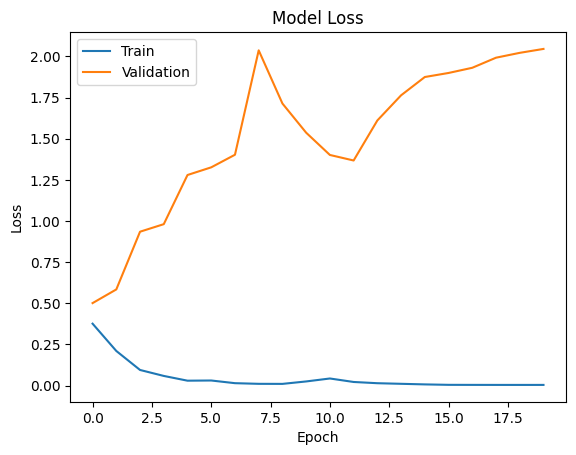

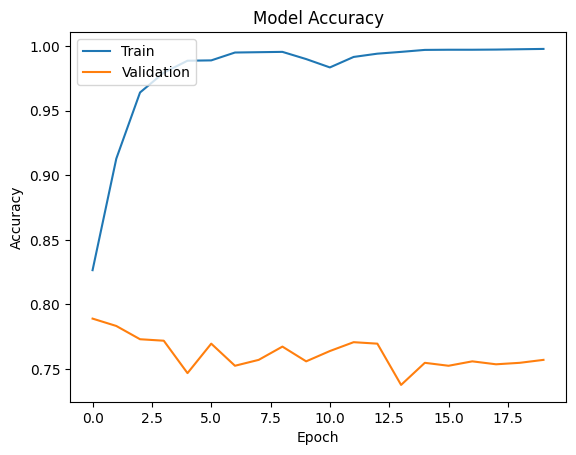

In [50]:
history = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=20, 
          batch_size=64, 
          verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation




In [32]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

183/183 [==============================] - 1s 4ms/step - loss: 1.9628 - accuracy: 0.7305
Accuracy: 73.05%


In [33]:
predictions = model.predict(X_test).ravel()
predictions[:10]

183/183 [==============================] - 1s 2ms/step


array([1.7871895e-05, 1.0000000e+00, 9.5355487e-01, 5.3257241e-05,
       1.3077826e-05, 4.6863444e-02, 1.0623979e-01, 9.9997091e-01,
       2.4594847e-02, 9.9999988e-01], dtype=float32)

In [34]:
predictions = ['liked course' if item == 1 else 'disliked course' for item in predictions]
predictions[:10]

['disliked course',
 'liked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course',
 'disliked course']

In [35]:
from sklearn.metrics import classification_report
labels = ['disliked course', 'liked course']
y_pred = model.predict(X_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=labels))

183/183 [==============================] - 0s 2ms/step
                 precision    recall  f1-score   support

disliked course       0.62      0.49      0.55      1958
   liked course       0.77      0.85      0.81      3889

       accuracy                           0.73      5847
      macro avg       0.70      0.67      0.68      5847
   weighted avg       0.72      0.73      0.72      5847



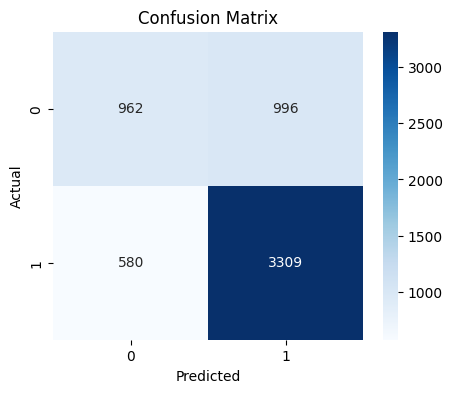

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()